In [12]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from astropy.io import fits
import os
from scipy.stats import binned_statistic

# How to use code and generate plots for the A100-SDSS paper (Durbala+2020) #


# Source Catalogs #


| Catalog | Filename | Size | Description | Source |
|---------|-------------|-----|----|-------|
| A100 HI catalog |a100.HIparms.191001.csv | 6.1M | A100 HI table | M. Haynes |
| SDSS catalog | a100.code12.SDSSvalues200409.csv| 23M | SDSS values for A100 | M. Haynes|
| NSA catalog |nsa_v1_0_1_vmax20k.fits  | 750M | NSA v1, with max vr=20k | https://www.sdss.org/dr14/manga/manga-target-selection/nsa/ |
| GSWLC-2 catalog | gswlc-A2-sdssphot.v2.vmax20k.fits|69M |gswlc cat w/sdss phot and vr < 20k | http://pages.iu.edu/~salims/gswlc/|
| GSWLC-2 SDSS catalog |Table_sdss_GSWLC_adurbala_new.csv | 315M | SDSS values for GSWLC | A. Durbala | 
| S4G catalog |spitzer.s4gcat_5173.tbl | 2.8M | s4g catalog | https://irsa.ipac.caltech.edu/data/SPITZER/S4G/overview.html| 
| unWise photometry | a100.SDSSObjID.191001.match3.unwise.fits | 7.4M |unWISE matched by SDSS Obj ID | D. Lang |
 

Some catalog preparation was done outside of the code demonstrated here.




## Notes on Ingesting GSWLC Catalog ###

- downloaded catalog gswlc-A2 (640,659 objects)
  - http://pages.iu.edu/~salims/gswlc/
  - unzip
```
gunzip GSWLC-A2.dat.gz 
```

  - created a header string (file doesn't have header) http://pages.iu.edu/~salims/gswlc/table2.pdf
```
# objide glxid plate mjd fiberid ra dec z chisq logmass e_logmass logsfr e_logsfr afuv e_afuv ab e_ab av e_av flag_sed uv_servey flag_uv flag_midir flag_mgs
```

  - read into topcat as an ascii file
- downloaded Adriana's catalog with SDSS photometry and errors 
  - https://drive.google.com/drive/folders/1P3ooZ5euqK8DvpsgT_2b5eOgtma6XT0-
  - Table_sdss_GSWLC_adurbala_AD.csv
  
- matched tables in topcat according to Adriana's directions
  - Sky match (RA, DEC), 0.5" error
     - RA,DEC in GSWLC catalog
     - radeg, decdeg in Adriana's catalog
  - found match for every galaxy - phew
  - output is gswlc-A2-sdssphot.fits (format just fits)

  
### UPDATE - MATCHING BY SDSS ID - JULY 6, 2020 ###

Using topcat:
* read in gswlc-A2 file
* read in Adriana's csv file: Table_sdss_GSWLC_adurbala_new.csv
* exact match using sdssobjid
  * GSWLC: ObjID
  * adriana's table: 
  * found 640596 matches
  * save file as gswlc-A2-sdssphot.v2.fits in research/APPSS/tables/
* update match_catalogs.py to read the new gswlc file


### Cut NSA and GSWLC to include vr < 20 k Galaxies Only ###

This significantly decreases the time to match the catalogs.





In [13]:
homedir = os.getenv("HOME")

In [14]:
tabledir = homedir+'/github/a100sdss/tables/'
plotdir = os.getcwd()

## Incorporating unWISE #

Dustin Lang provided catalog of matched unWISE sources

- 219 galaxies are matched to multiple unWISE sources
- 1 galaxies is matched to 3 sources (the rest are matched to 2)


## Cleaning unWISE Catalog #

- combining fluxes for entries with double matches
- write out cleaned file
- clean_unwise_catalog.py
  - reads in tabledir+'/a100.SDSSObjID.191001.match3.unwise.fits'
  - writes out outfile = tabledir+'/a100.SDSSObjID.191001.match3.unwise-cleaned.fits'


In [11]:
%run ~/github/APPSS/clean_unwise_catalog.py

number of AGC with multiple unWISE matches =  219
number of sources with multiple matches =  219
	 number of sources with 2 matches =  218
	 number of sources with 3 matches =  1


<Figure size 432x288 with 0 Axes>

# To Generate Catalogs #



- the catalogs are created by **match_catalogs.py**
- doesn't like to run in the notebook (kernel keeps dying), so:
```
python ~/github/APPSS/match_catalogs.py
```



## Notes ##
- NSA abs mags are for H0=100 
- we calculate our own absolute magnitudes using the internal extinction-corrected magnitudes and the distance that is in the a100 catalog.


* to run with abs mag from NSA, set useNSAnuv to true in calc_sfrnuv_ke(self):


In [5]:
# I am importing the program so I can print out the documentation at the beginning
# you don't need to do this - just read documentation below and skip to the next cell
import match_catalogs
help(match_catalogs)

--- 7.319450378417969e-05 seconds ---
Help on module match_catalogs:

NAME
    match_catalogs

DESCRIPTION
    GOALS:
    - match A100 catalog to:
      - sdss phot cat
      - unwise matches
    
    - match a100-sdss-wise cat to:
      - nsa
      - gswlc
      - s4g
    - this calculates match statistics for full surveys
    - re-do match for overlap regions
      - print statistics for this match too
    - produces catalogs for OVERLAP REGION ONLY
    
    - also matches full a100 to other catalogs to produce 
      one catalog with everything
      - this cuts the nsa and gswlc by vr < 15500 before matching to a100 to save memory
    
    USAGE:
    
    - to create catalogs for overlap regions:
    
      python ~/github/APPSS/match_catalogs.py --matchoverlap
    
    - to create catalog for full a100 table:
    
      python ~/github/APPSS/match_catalogs.py --matchoverlap
    
    OUTPUTS:
    
    - a100-sdss.fits (FULL A100)
      - a100 matched to sdss phot
    - a100-sdss-wi

In [6]:
# for a more abbreviated help, type
%run ~/github/APPSS/match_catalogs.py --help


usage: match_catalogs.py [-h] [--matchoverlap] [--matchfull]

Match catalogs for A100-SDSS paper

optional arguments:
  -h, --help      show this help message and exit
  --matchoverlap  set this to match catalogs in overlap region and write out
                  catalogs for paper analysis.
  --matchfull     set this to match catalogs to the full a100 catalog. this
                  will produce full-a100-sdss-wise-nsa-gswlcA2.fits, the full
                  a100+sdss catalog with AALLL the other columns that you
                  could ever want.


In [54]:
# to run the catalog and create the overlap region tables that are used in the paper analysis
%run ~/github/APPSS/match_catalogs.py --matchoverlap --matchfull

number of rows in a100 table AFTER joining HI and SDSS params =  31501
/home/rfinn/github/a100sdss/tables//gswlc-A2-sdssphot.v2.vmax20k.fits
INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]
################################

MATCHING TO NSA 

################################
FULL CATALOGS, BEFORE MATCHING
total number in A100 =  31501
total number in NSA =  204605
AFTER MATCHING
total number in A100 =  31501
total number in NSA =  204605
number of unique galaxies =  213246
number of matches between A100 and NSA =  22860
number in A100 but not in NSA =  8641
number in NSA but not in A100 =  181745

OVERLAP VOLUME, BEFORE MATCHING
total number in A100 =  15467
total number in NSA =  42999

OVERLAP VOLUME, AFTER MATCHING
total number in A100 =  15467
total number in NSA =  42999
number of unique galaxies =  44919
number of matches between A100 and NSA =  13547
number in A100 but not in NSA =  1920
number in NSA but not in A100 = 

<Figure size 432x288 with 0 Axes>

# Paper Figures #

- the code to generate paper plots is in **a100sdss.py**

In [ ]:
# just to show the documentation (or lack thereof) for a100sdss.py
import a100sdss
help(a100sdss)

# Internal Extinction Correction #

I'm trying...
I'm trying...


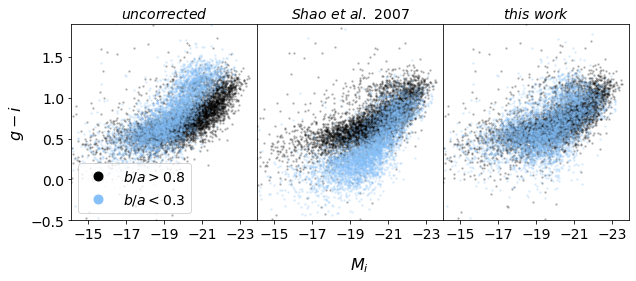

In [13]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.figure1()

# Detection Fraction of A100 Galaxies as a function of stellar mass#

- limit to photFlag_gi_1 == 1

<Figure size 432x288 with 0 Axes>

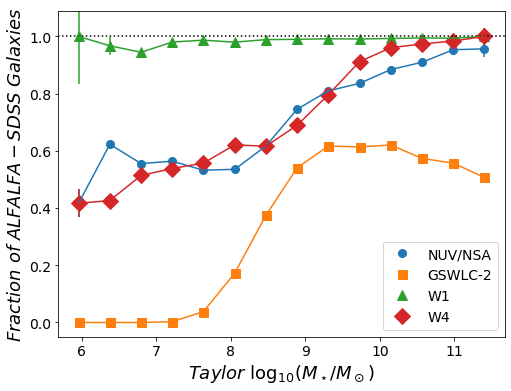

In [14]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.detection_fractions()


<Figure size 432x288 with 0 Axes>

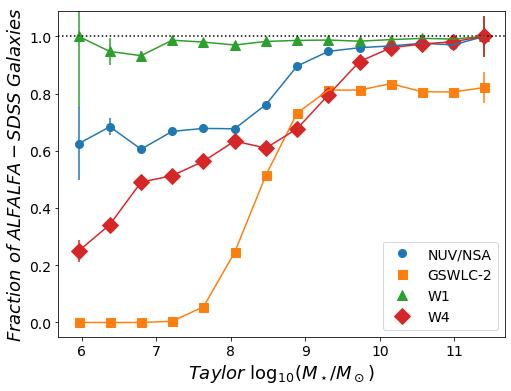

In [15]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.detection_fractions(overlap=True)

# Skyplot showing distribution of A100 and comparison surveys #

http://learn.astropy.org/plot-catalog.html



got here
got here


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

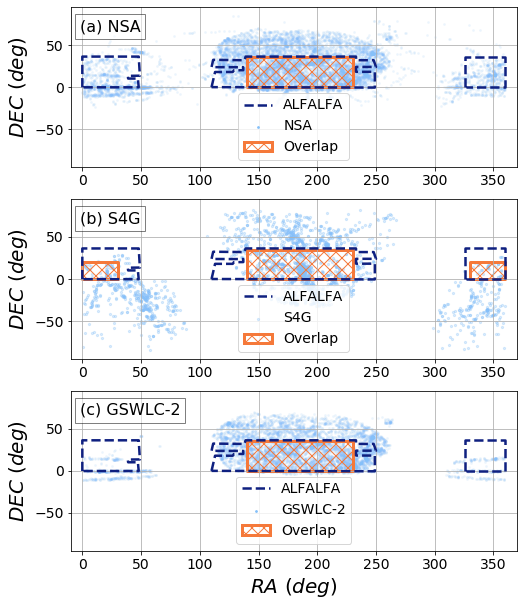

In [55]:
%run ~/github/APPSS/skyplot.py

# Comparison of Stellar Mass Estimates #

* we compare stellar mass estimates from 
  * Taylor+2011 (from optical, uses g-i)
  * McGaugh+2015? (using W1)
  * Cluver+20?? (uses W1-W2 color) 

<Figure size 432x288 with 0 Axes>

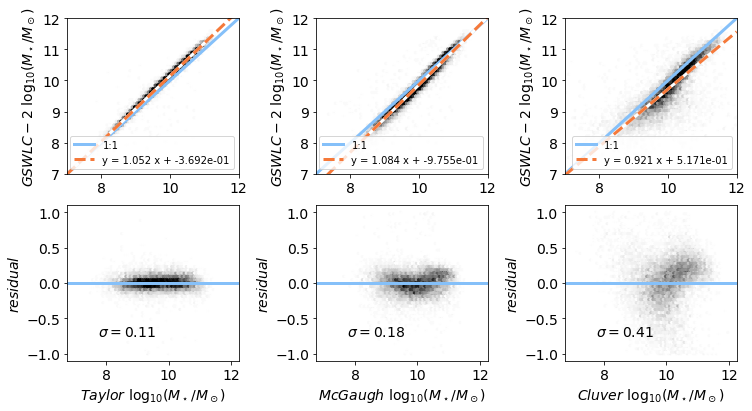

In [52]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
fp.fit_mstar()

# Comparing SFRs #

- these are not as easy to fit as the stellar masses, maybe because there is more scatter
- looking into robust bisector linear fit mentioned in Salim+2016.

fitting offset only
fitting offset only
fitting offset only


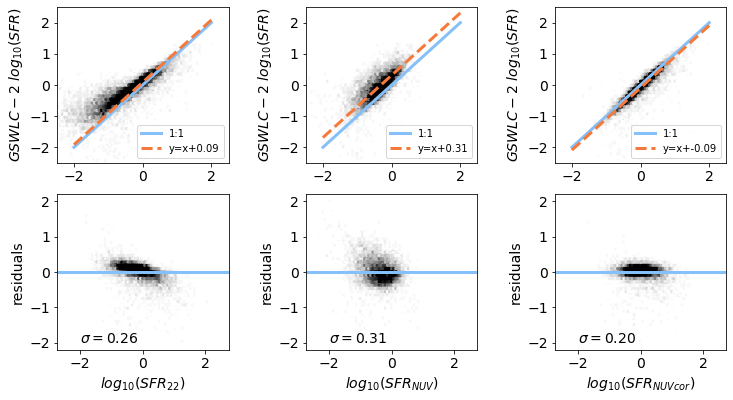

In [31]:
# with new tables from Sep 2020
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
fp.fit_sfr(norder=0,snr_cut=3)

# Comparing Color vs Stellar Mass#

## A100 - NSA ##

number of galaxies in NSA + A100 sample =  13119
28318 28318
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.06
p-value = 5.97e-33 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.27
p-value = 0.00e+00 (prob that samples are from same distribution)


array([ True,  True,  True, ..., False, False, False])

<Figure size 432x288 with 0 Axes>

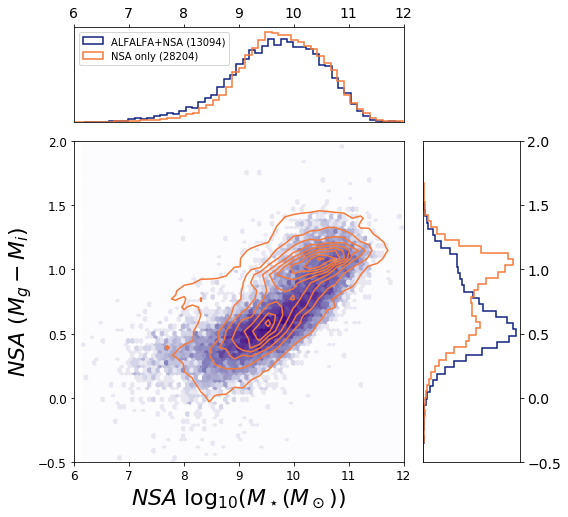

In [53]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.figa_nsa()

1441 1441
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.45
p-value = 8.45e-228 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.29
p-value = 2.06e-92 (prob that samples are from same distribution)


<Figure size 432x288 with 0 Axes>

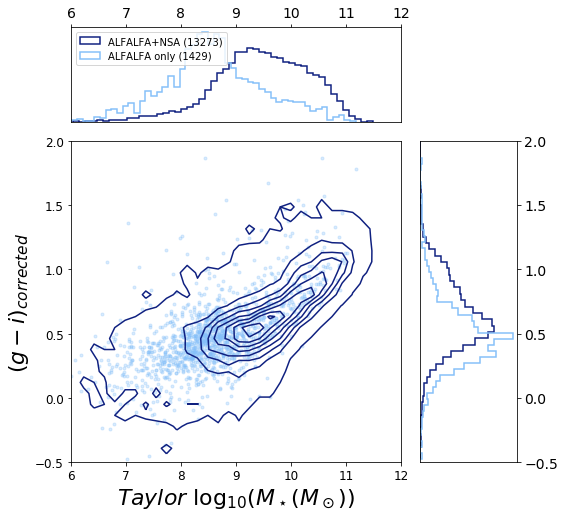

In [54]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.figb_nsa()

## A100 vs S4G ##

number with both =  541
number with S4G only =  66
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.25
p-value = 1.94e-02 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.68
p-value = 6.66e-16 (prob that samples are from same distribution)


<Figure size 432x288 with 0 Axes>

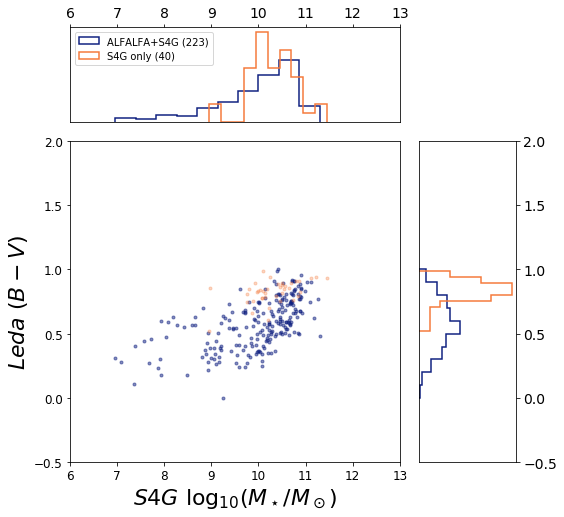

In [55]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.figa_s4g()

[  2.          46.22222222  90.44444444 134.66666667 178.88888889
 223.11111111 267.33333333 311.55555556 355.77777778 400.        ]
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.12
p-value = 1.36e-06 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.24
p-value = 1.05e-23 (prob that samples are from same distribution)


<Figure size 432x288 with 0 Axes>

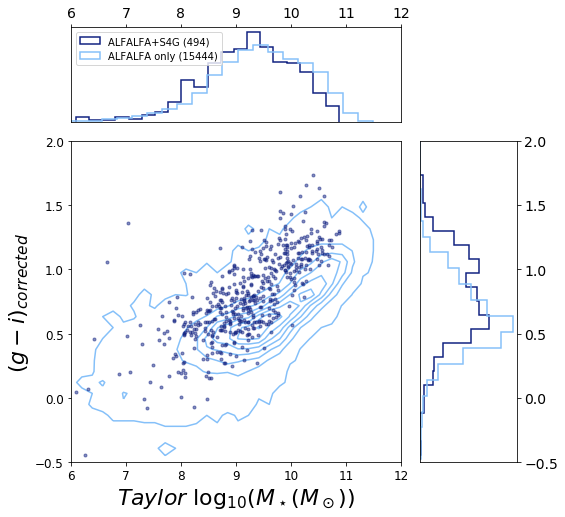

In [56]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.figb_s4g()

## A100 vs GSWLC ##

############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.07
p-value = 1.72e-34 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.33
p-value = 0.00e+00 (prob that samples are from same distribution)


<Figure size 432x288 with 0 Axes>

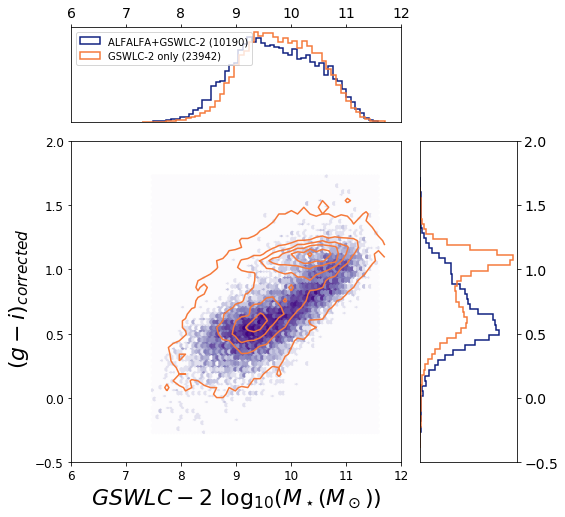

In [57]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
t = p.figa_gswlc()

############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.38
p-value = 0.00e+00 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.15
p-value = 1.21e-61 (prob that samples are from same distribution)


<Figure size 432x288 with 0 Axes>

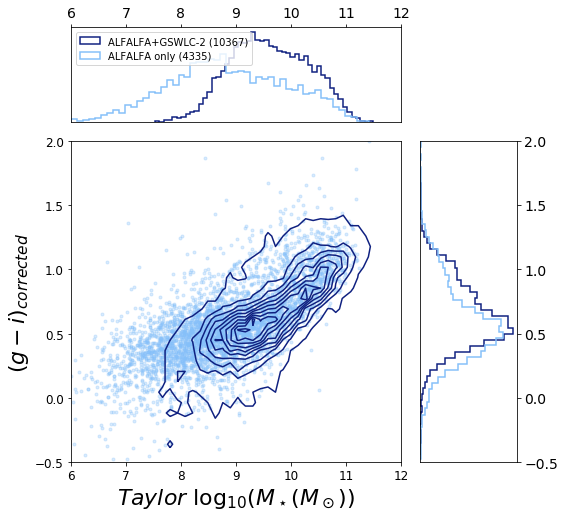

In [58]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
t = p.figb_gswlc()

# A100-GSWLC: sSFR - Mstar #

############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.07
p-value = 6.07e-27 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.14
p-value = 5.90e-110 (prob that samples are from same distribution)


array([ True,  True,  True, ...,  True,  True,  True])

<Figure size 432x288 with 0 Axes>

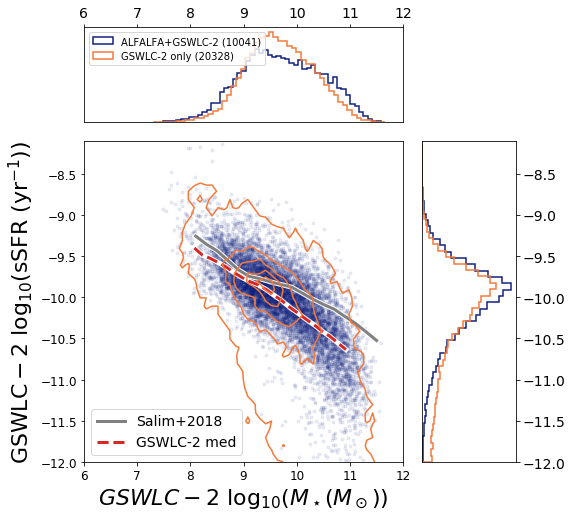

In [59]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.ssfrmstar_gswlc(ssfrlimit=-15,plotssfrline=True)

number in overlap region with NUVIR SFR =  9716
number in overlap region with NUV SFR =  11742
number in overlap region with IR SFR =  14738
number of a100 with W4 and NUV detections, in GSWLC overlap =  9716
number of those NOT in GSWLC =  1540
number in flag2 =  1540
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.34
p-value = 7.69e-133 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.11
p-value = 1.00e+00 (prob that samples are from same distribution)


array([ True,  True,  True, ...,  True,  True,  True])

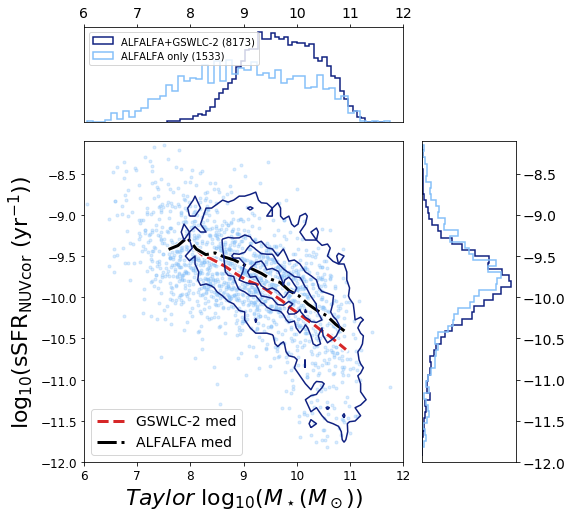

In [56]:
# with mean instead of median
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.ssfrmstar_a100(ssfrlimit=-15,useTaylor=True)

Should do a test over range where samples are similar.  do we get higher sSFRs for alfalfa galaxies, after controlling for stellar mass?

Need to cut on sSFR and stellar mass



# A100-GSWLC: SFR vs Mstar #

############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.07
p-value = 2.86e-35 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.23
p-value = 0.00e+00 (prob that samples are from same distribution)


<Figure size 432x288 with 0 Axes>

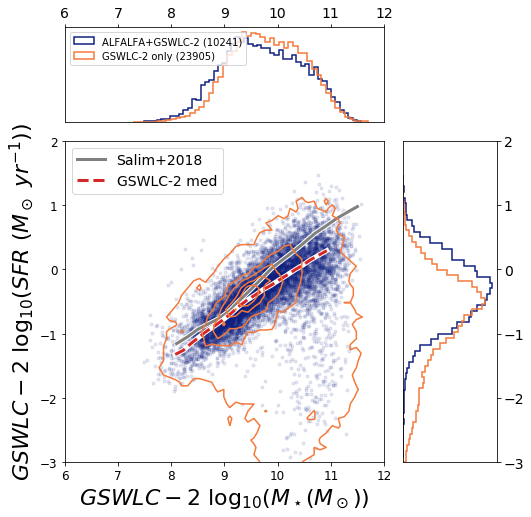

In [57]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.sfrmstar_gswlc()

number with a100_flag =  13300
number of those NOT in GSWLC =  3177
number in flag2 =  3177
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test (median of bootstrap):
D =   0.34
p-value = 5.70e-132 (prob that samples are from same distribution)

COLOR
KS Test (median of bootstrap):
D =   0.38
p-value = 1.23e-162 (prob that samples are from same distribution)
saving taylor files


<Figure size 432x288 with 0 Axes>

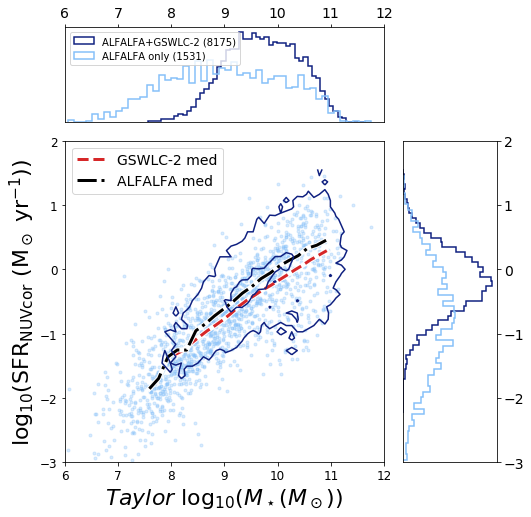

In [58]:
os.chdir('/home/rfinn/research/APPSS/plots/')
%run ~/github/APPSS/a100sdss.py
p.sfrmstar_a100(useTaylor=True)

# Write tables for paper#

- writetables.py calculates several errors and writes latex files for tables 1 and 2
- output is written to tablepath, where
```
homedir = os.getenv('HOME')
latextablepath = homedir+'/research/APPSS/latex-tables/'
```

- Then upload table1.tex and table2.tex to overleaf.

- Martha added expABErr_r to tables - rerunning



In [59]:
%run ~/github/APPSS/writetables.py

length of tab2 =  31501  should be 31502
galaxies with UV+IR sfr err = inf


<Figure size 432x288 with 0 Axes>